In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import sem
from scipy.stats import linregress

# Data Load/Setup

In [2]:

# Import CSV files
#Files currently being used
emissions_df = pd.read_csv('Resources/co2_emissions_kt_by_country.csv')
pesticide_use_df = pd.read_csv('Resources/pesticide-use-tonnes.csv')
population_df = pd.read_csv('Resources/population.csv')
land_allotment_df = pd.read_csv('Resources/Land/API_AG.LND.AGRI.ZS_DS2_en_csv_v2_3416072.csv')
crop_yields_df = pd.read_csv('Resources/crop_yields.csv')


cc_Impact_Agri_df = pd.read_csv('Resources/climate_change_impact_on_agriculture_2024.csv')
agroFood_df = pd.read_csv('Resources/Agrofood_co2_emission.csv')
owid_co2_c_df = pd.read_csv('Resources/owid-co2-data.csv')


In [3]:
# Merge dataframes: emissions_df, pesticide_use_df, population_df
df = pd.merge(emissions_df, pesticide_use_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.rename(columns = {
    "country_name": "country",
    "value": "co2_emissions",
    "Pesticides (total) | 00001357 || Agricultural Use | 005157 || Tonnes": "pesticide_by_tonnes"
})
df = df.drop(columns = ['Entity', 'Code', 'Year'])
df = pd.merge(df, population_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
# df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "Population (historical)": "population"
})
df = df.drop(columns = ['Entity', 'Code', 'Year'])
df

,country_code,country,year,co2_emissions,pesticide_by_tonnes,population
0,ABW,Aruba,1990,487.711000,148.21,64452
1,ABW,Aruba,1991,531.715000,155.18,66564
2,ABW,Aruba,1992,539.049000,169.10,68889
3,ABW,Aruba,1993,649.059000,189.98,71090
4,ABW,Aruba,1994,660.060000,210.87,73476
...,...,...,...,...,...,...
5658,ZWE,Zimbabwe,2015,12430.000305,2185.07,14399009
5659,ZWE,Zimbabwe,2016,11020.000458,2185.07,14600297
5660,ZWE,Zimbabwe,2017,10340.000153,2185.07,14812484
5661,ZWE,Zimbabwe,2018,12380.000114,2185.07,15034457


In [4]:
# Modifying agricultural land allotment df
land_modified_df = land_allotment_df.drop(columns = ['Indicator Name', 'Country Code', 'Indicator Code'])


df_long = pd.melt(land_modified_df, id_vars=['Country Name'], var_name = 'year', value_name ='% of Agricultural Land')
df_long.rename(columns={'Country Name': 'country'}, inplace=True)
df_long_sorted_df = df_long.sort_values(by=['country', 'year'])
df_long_sorted_df = df_long_sorted_df.reset_index(drop = True)

indicies_to_drop = df_long_sorted_df[df_long_sorted_df['year'] == 'Unnamed: 68'].index
df_long_sorted_df.drop(index = indicies_to_drop, inplace=True)

df_long_sorted_df['year'] = df_long_sorted_df['year'].astype(np.int64)
land_final_df = df_long_sorted_df
land_final_df

,country,year,% of Agricultural Land
0,Afghanistan,1960,NaN
1,Afghanistan,1961,57.878356
2,Afghanistan,1962,57.955016
3,Afghanistan,1963,58.031676
4,Afghanistan,1964,58.116002
...,...,...,...
17284,Zimbabwe,2019,41.876696
17285,Zimbabwe,2020,41.876696
17286,Zimbabwe,2021,41.876696
17287,Zimbabwe,2022,NaN


In [5]:
#Merging main df with % of agricultural land df
main_df = pd.merge(df, land_final_df, how = 'left', left_on = ['country', 'year'], right_on = ['country', 'year']).dropna()
main_df


,country_code,country,year,co2_emissions,pesticide_by_tonnes,population,% of Agricultural Land
0,ABW,Aruba,1990,487.711000,148.21,64452,11.111111
1,ABW,Aruba,1991,531.715000,155.18,66564,11.111111
2,ABW,Aruba,1992,539.049000,169.10,68889,11.111111
3,ABW,Aruba,1993,649.059000,189.98,71090,11.111111
4,ABW,Aruba,1994,660.060000,210.87,73476,11.111111
...,...,...,...,...,...,...,...
5658,ZWE,Zimbabwe,2015,12430.000305,2185.07,14399009,41.876696
5659,ZWE,Zimbabwe,2016,11020.000458,2185.07,14600297,41.876696
5660,ZWE,Zimbabwe,2017,10340.000153,2185.07,14812484,41.876696
5661,ZWE,Zimbabwe,2018,12380.000114,2185.07,15034457,41.876696


In [6]:
# Modifying crop_yields_df so that it shows sum crop yield within each country's year
# Note: crop yields are in tonnes per hecatare
crop_yields_df
test_crop_df = crop_yields_df
all_columns = crop_yields_df.columns.tolist()
crop_columns = all_columns[2:]
crop_yields_df['Total_Crop_Yield'] = crop_yields_df[crop_columns].sum(axis=1)

crop_yields_df = test_crop_df.drop(columns=crop_columns)
crop_yields_df

,country,year,Total_Crop_Yield
0,Afghanistan,1961,497.218199
1,Afghanistan,1962,500.500606
2,Afghanistan,1963,500.690099
3,Afghanistan,1964,508.990498
4,Afghanistan,1965,517.870401
...,...,...,...
14572,Zimbabwe,2018,780.655493
14573,Zimbabwe,2019,777.940795
14574,Zimbabwe,2020,778.620694
14575,Zimbabwe,2021,778.041794


In [7]:
#Merging main df with crop_yields_df
main_df = pd.merge(main_df, crop_yields_df, how = 'left', left_on = ['country', 'year'], right_on = ['country', 'year']).dropna()
main_df = main_df.reset_index(drop = True)
main_df

,country_code,country,year,co2_emissions,pesticide_by_tonnes,population,% of Agricultural Land,Total_Crop_Yield
0,AGO,Angola,1990,6560.000000,64.00,11626359,35.658940,483.756493
1,AGO,Angola,1991,6670.000000,79.00,12023533,35.680597,509.062100
2,AGO,Angola,1992,6880.000000,23.00,12423717,35.703056,508.292294
3,AGO,Angola,1993,9270.000000,169.00,12827135,35.702254,509.404693
4,AGO,Angola,1994,11300.000000,25.50,13249762,35.702254,517.118693
...,...,...,...,...,...,...,...,...
4671,ZWE,Zimbabwe,2015,12430.000305,2185.07,14399009,41.876696,775.884894
4672,ZWE,Zimbabwe,2016,11020.000458,2185.07,14600297,41.876696,777.129893
4673,ZWE,Zimbabwe,2017,10340.000153,2185.07,14812484,41.876696,774.345388
4674,ZWE,Zimbabwe,2018,12380.000114,2185.07,15034457,41.876696,780.655493


In [15]:
# Isolate United States as test 
us_df = main_df[main_df['country'] == 'United States']
us_df

,country_code,country,year,co2_emissions,pesticide_by_tonnes,population,% of Agricultural Land,Total_Crop_Yield
4496,USA,United States,1990,4.844520e+06,400975.94,253373385,46.615336,1651.036173
4497,USA,United States,1991,4.807500e+06,384646.38,256471425,46.615336,1682.192386
4498,USA,United States,1992,4.879630e+06,400975.90,259606020,46.449488,1744.338593
4499,USA,United States,1993,4.995210e+06,391903.88,262633235,46.178605,1732.181281
4500,USA,United States,1994,5.066810e+06,425922.70,265474811,45.981094,1785.452582
4501,USA,United States,1995,5.117040e+06,423201.53,268205794,45.871911,1739.594488
4502,USA,United States,1996,5.273490e+06,433180.38,270860696,45.453414,1744.210884
4503,USA,United States,1997,5.543350e+06,434540.75,273468014,45.298265,1859.612087
4504,USA,United States,1998,5.590540e+06,424562.12,276119323,45.265838,1787.436981
4505,USA,United States,1999,5.609020e+06,433633.97,278785482,45.189301,1839.230788


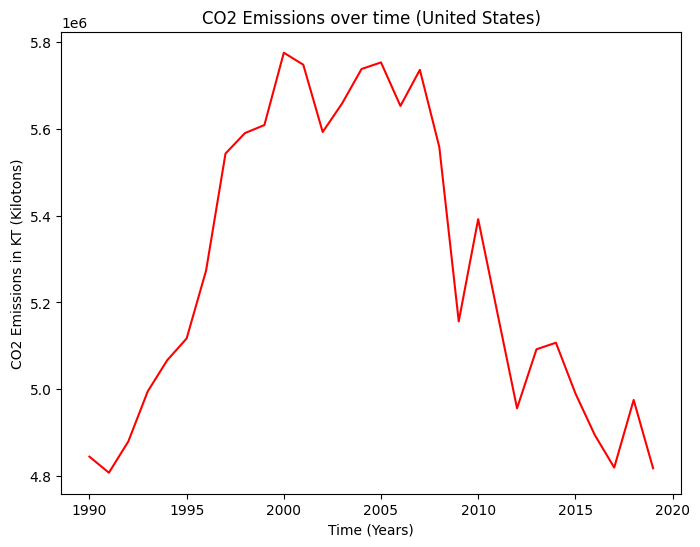

In [16]:
#plot of co2 emissions over time in United States
plt.figure(figsize=(8,6))

plt.plot(us_df['year'], us_df['co2_emissions'], linestyle='-',
         color='red')
plt.title('CO2 Emissions over time (United States)')
plt.xlabel('Time (Years)')
plt.ylabel('CO2 Emissions in KT (Kilotons)')


plt.show()

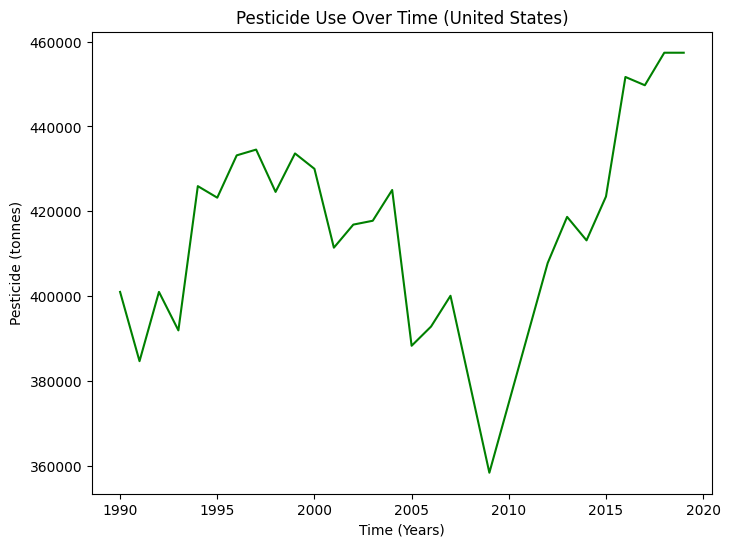

In [9]:
#United States Pesticide usage
plt.figure(figsize=(8,6))

plt.plot(us_df['year'], us_df['pesticide_by_tonnes'], linestyle='-',
         color='green')
plt.title('Pesticide Use Over Time (United States)')
plt.xlabel('Time (Years)')
plt.ylabel('Pesticide (tonnes)')

plt.show()

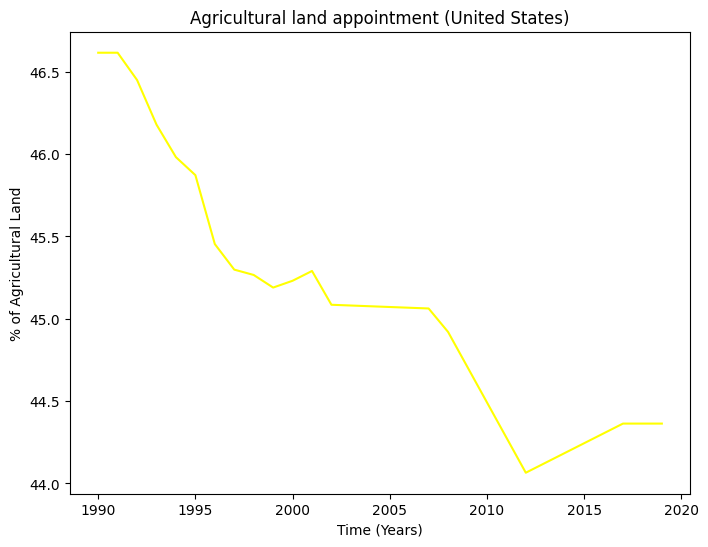

In [10]:
#United States agriculture land appointment
plt.figure(figsize=(8,6))

plt.plot(us_df['year'], us_df['% of Agricultural Land'], linestyle='-',
         color='yellow')
plt.title('Agricultural land appointment (United States)')
plt.xlabel('Time (Years)')
plt.ylabel('% of Agricultural Land')

plt.show()

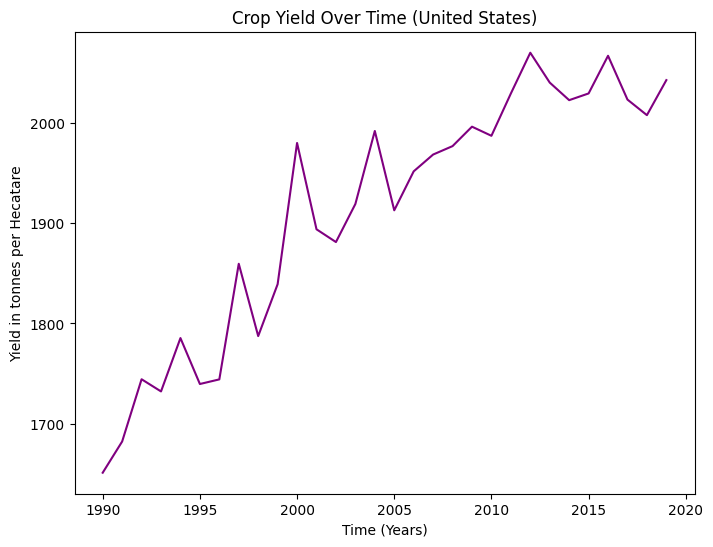

In [14]:
#United States crop yield over time
plt.figure(figsize=(8,6))

plt.plot(us_df['year'], us_df['Total_Crop_Yield'], linestyle='-',
         color='purple')
plt.title('Crop Yield Over Time (United States)')
plt.xlabel('Time (Years)')
plt.ylabel('Yield in tonnes per Hecatare')

plt.show()

The correlation between Agricultural Land assignment and CO2 Emissions is 0.08


<Figure size 800x600 with 0 Axes>

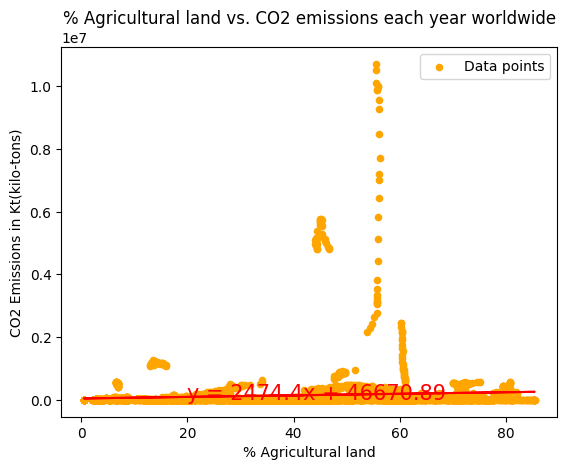

In [11]:
#Scatter plot of agri land vs co2 emi
main_df

#scatter plot of 
x_axis_world = main_df['% of Agricultural Land']
y_axis_world = main_df['co2_emissions']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between Agricultural Land assignment and CO2 Emissions is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='% of Agricultural Land', 
                             y='co2_emissions', color='orange')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")

plt.title('% Agricultural land vs. CO2 emissions each year worldwide')
plt.xlabel('% Agricultural land')
plt.ylabel('CO2 Emissions in Kt(kilo-tons)')


plt.show()

The correlation between land use and pesticide use is 0.04


<Figure size 800x600 with 0 Axes>

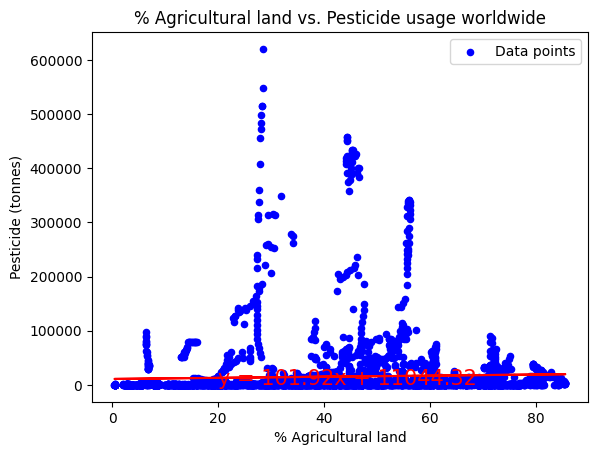

In [12]:
#Scatter plot of land vs pesticide
main_df

#scatter plot of 
x_axis_world = main_df['% of Agricultural Land']
y_axis_world = main_df['pesticide_by_tonnes']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between land use and pesticide use is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='% of Agricultural Land', 
                             y='pesticide_by_tonnes', color='blue')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="green")

plt.title('% Agricultural land vs. Pesticide usage worldwide')
plt.xlabel('% Agricultural land')
plt.ylabel('Pesticide (tonnes)')


plt.show()

The correlation between land use and population is 0.12


<Figure size 800x600 with 0 Axes>

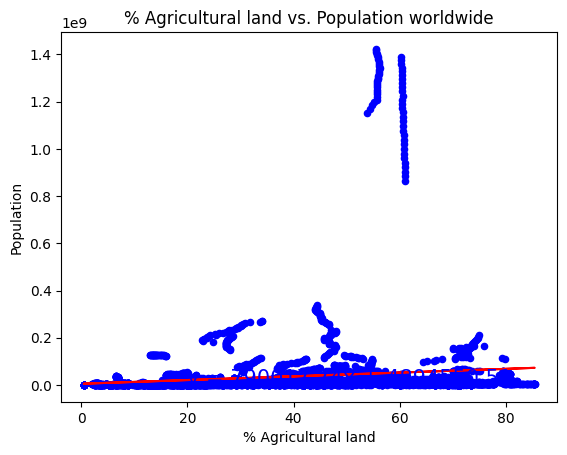

In [22]:
#Scatter plot of land vs pop
main_df
#scatter plot of 
x_axis_world = main_df['% of Agricultural Land']
y_axis_world = main_df['population']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between land use and population is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='% of Agricultural Land', 
                             y='population', color='blue')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="blue")

plt.title('% Agricultural land vs. Population worldwide')
plt.xlabel('% Agricultural land')
plt.ylabel('Population')

plt.show()

The correlation between land use and total crop yield is 0.09


<Figure size 800x600 with 0 Axes>

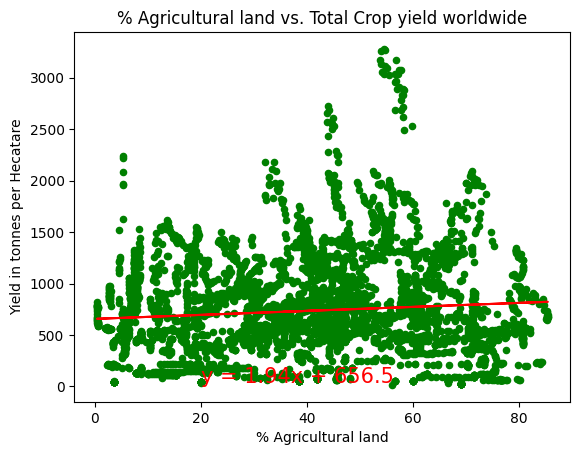

In [23]:
#Scatter plot of land vs total crop yield
main_df

#scatter plot of 
x_axis_world = main_df['% of Agricultural Land']
y_axis_world = main_df['Total_Crop_Yield']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between land use and total crop yield is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='% of Agricultural Land', 
                             y='Total_Crop_Yield', color='green')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")

plt.title('% Agricultural land vs. Total Crop yield worldwide')
plt.xlabel('% Agricultural land')
plt.ylabel('Yield in tonnes per Hecatare')


plt.show()


The correlation pesticide and co2 emissions is 0.73


<Figure size 800x600 with 0 Axes>

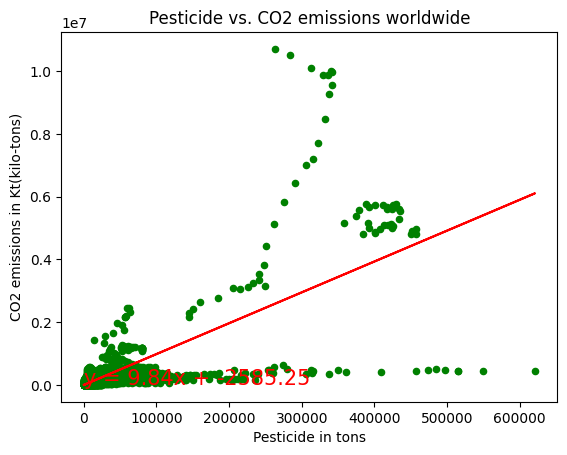

In [26]:
#Scatter plot of world wide pesticide versus co2

#scatter plot of 
x_axis_world = main_df['pesticide_by_tonnes']
y_axis_world = main_df['co2_emissions']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation pesticide and co2 emissions is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='pesticide_by_tonnes', 
                             y='co2_emissions', color='green')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")

plt.title('Pesticide vs. CO2 emissions worldwide')
plt.xlabel('Pesticide in tons')
plt.ylabel('CO2 emissions in Kt(kilo-tons)')


plt.show()

The correlation between Pesticide Use and CO2 Emissions is 0.99


<Figure size 800x600 with 0 Axes>

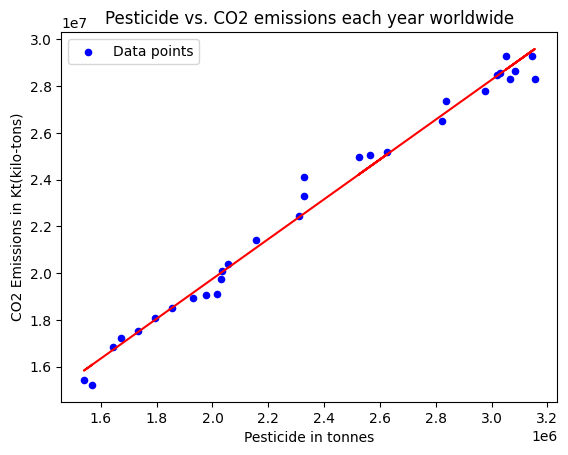

In [25]:
#Creating scatter plot using summation of all country's pesticide use per year by all 
#country's co2 emissions per year
main_df
grouped_holder_world = main_df.groupby('year').agg({'pesticide_by_tonnes': 'sum',
                                                             'co2_emissions': 'sum'})
world_grouped_df = grouped_holder_world.reset_index()
# world_grouped_df

#scatter plot of 
x_axis_world = world_grouped_df['pesticide_by_tonnes']
y_axis_world = world_grouped_df['co2_emissions']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between Pesticide Use and CO2 Emissions is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
world_grouped_df.plot.scatter(x='pesticide_by_tonnes', 
                             y='co2_emissions', color='blue')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")

plt.title('Pesticide vs. CO2 emissions each year worldwide')
plt.xlabel('Pesticide in tonnes')
plt.ylabel('CO2 Emissions in Kt(kilo-tons)')

plt.legend(['Data points'])
plt.show()

In [38]:
#List of all country names in dataset
country_names = main_df["country"].unique()
country_names_list = country_names.tolist()
# country_names_list

In [ ]:
country_dict = {}
for _, row in country_grouped_df.iterrows():
    country = row['Country']
    year = row['Year']
    if country not in country_dict:
        country_dict[country] = {'Year': [], 'Pesticide_Use_KG_per_HA': [], 'CO2_Emissions_MT': []}
    country_dict[country]['Year'].append(year)
    country_dict[country]['Pesticide_Use_KG_per_HA'].append(row['Pesticide_Use_KG_per_HA'])
    country_dict[country]['CO2_Emissions_MT'].append(row['CO2_Emissions_MT'])